<a href="https://colab.research.google.com/github/Van-Wu1/CECI/blob/main/scr/py/validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Mounted at /content/drive
BoroughShp  CQI  GreatLondonShp  s1  s2_Env  s3


In [ ]:
!pip -q install geopandas shapely pyproj rtree pyogrio fiona scipy matplotlib pandas

import os, glob
import pandas as pd
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 614.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 53.9 MB/s eta 0:00:00


In [ ]:
BASE_DIR = "/content/drive/MyDrive/CASA0004_Cycling/data/tfl_counts_2024W1"
PATTERN_COUNTS = os.path.join(BASE_DIR, "2024 W1 spring-*.csv")
FILE_SITES = os.path.join(BASE_DIR, "Monitoring locations.csv")

FILE_CECI  = os.path.join(BASE_DIR, "ceci_roads.gpkg")

COL_CECI   = "cqi_index"

CYCLE_MODES = {"Conventional cycles", "Cycle hire bikes", "Private cycles"}

HOUR_START, HOUR_END = 7, 19

MAX_NEAREST_DIST_M = 100

In [ ]:
# === 读取并合并 2024 春季 CSV ===
files = sorted(glob.glob(PATTERN_COUNTS))
assert files, f"没有找到CSV，检查通配：{PATTERN_COUNTS}"

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)
print("Raw shape:", raw.shape)
print("Columns:", list(raw.columns)[:15])

# 基础清洗
need_cols = ["SiteID", "Date", "Time", "Day", "Mode", "Count"]
for c in need_cols:
    assert c in raw.columns, f"缺少列：{c}"
df = raw[need_cols].copy()

# 字段清洗
df["Count"] = pd.to_numeric(df["Count"], errors="coerce")
df = df.dropna(subset=["Count"])

# Mode 过滤（只留三类骑行）
df = df[df["Mode"].isin(CYCLE_MODES)].copy()

# 时间解析（Date+Time -> datetime，默认本地时间）
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce").dt.time
df = df.dropna(subset=["Date", "Time"])

dt = pd.to_datetime(df["Date"].dt.strftime("%Y-%m-%d") + " " + df["Time"].astype(str))
df["datetime"] = dt
df["hour"] = df["datetime"].dt.hour

# 仅工作日 + 07-19
df = df[(df["Day"].str.lower()=="weekday") & (df["hour"].between(HOUR_START, HOUR_END))].copy()

print("After filter:", df.shape)

# 汇总为 “站点-日期 的骑行总量”，再得到 “站点平均日流量”
# 先把三种 Mode 的 15分钟计数相加
grp_day = df.groupby(["SiteID","Date"], as_index=False)["Count"].sum().rename(columns={"Count": "daily_total"})
site_avg = grp_day.groupby("SiteID", as_index=False)["daily_total"].mean().rename(columns={"daily_total":"avg_daily_flow"})

print("Unique sites:", site_avg.shape[0])
site_avg.head()

Raw shape: (2302208, 11)
Columns: ['Wave', 'SiteID', 'Date', 'Weather', 'Time', 'Day', 'Round', 'Direction', 'Path', 'Mode', 'Count']
After filter: (476684, 8)
Unique sites: 1468


,SiteID,avg_daily_flow
0,ML0001,5755.0
1,ML0002,9660.0
2,ML0003,4708.0
3,ML0004,2571.0
4,ML0005,3495.4


In [ ]:
# 读取监测点坐标，并与站点平均日流量合并
sites = pd.read_csv(FILE_SITES)

# 只保留我们需要的列，并去重
need_cols = ["Site ID", "Longitude", "Latitude", "Easting (UK Grid)", "Northing (UK Grid)"]
for c in need_cols:
    if c not in sites.columns:
        print("列不存在：", c)
# 先复制一份，避免 SettingWithCopy 警告
sites2 = sites.copy()

# 尽量使用经纬度；若为字符串，转成数值
if "Longitude" in sites2.columns and "Latitude" in sites2.columns:
    sites2["Longitude"] = pd.to_numeric(sites2["Longitude"], errors="coerce")
    sites2["Latitude"]  = pd.to_numeric(sites2["Latitude"], errors="coerce")
    s_xy = sites2[["Site ID","Longitude","Latitude"]].dropna().drop_duplicates(subset=["Site ID"]).copy()

    # 先merge再建geometry
    m = s_xy.merge(site_avg, left_on="Site ID", right_on="SiteID", how="inner")
    g_sites = gpd.GeoDataFrame(
        m,
        geometry=gpd.points_from_xy(m["Longitude"], m["Latitude"]),
        crs="EPSG:4326"
    ).to_crs(27700)

else:
    # 回退用 Easting/Northing
    sites2["Easting (UK Grid)"]  = pd.to_numeric(sites2["Easting (UK Grid)"], errors="coerce")
    sites2["Northing (UK Grid)"] = pd.to_numeric(sites2["Northing (UK Grid)"], errors="coerce")
    s_en = sites2[["Site ID","Easting (UK Grid)","Northing (UK Grid)"]].dropna().drop_duplicates(subset=["Site ID"]).copy()

    m = s_en.merge(site_avg, left_on="Site ID", right_on="SiteID", how="inner")
    g_sites = gpd.GeoDataFrame(
        m,
        geometry=gpd.points_from_xy(m["Easting (UK Grid)"], m["Northing (UK Grid)"]),
        crs="EPSG:27700"
    )

print("sites(unique):", len(m))
print(g_sites.head(3))


sites(unique): 1468
  Site ID  Longitude   Latitude  SiteID  avg_daily_flow  \
0  ML0001  -0.125204  51.492628  ML0001          5755.0   
1  ML0002  -0.079254  51.519599  ML0002          9660.0   
2  ML0003  -0.094551  51.508123  ML0003          4708.0   

                        geometry  
0  POINT (530250.998 178742.012)  
1  POINT (533361.999 181823.953)  
2  POINT (532333.997 180520.042)  


In [ ]:
# 读取你的 CECI 道路数据，并做最近邻匹配
roads = gpd.read_file(FILE_CECI)
if roads.crs is None:
    roads.set_crs(epsg=27700, inplace=True)
else:
    roads = roads.to_crs(27700)

assert COL_CECI in roads.columns, f"CECI 列 {COL_CECI} 不存在，请修改 COL_CECI"

# 最近邻（监测点 最近路段）
joined = gpd.sjoin_nearest(
    g_sites,
    roads[[COL_CECI, "geometry"]],
    how="inner",
    distance_col="nearest_dist_m",
    max_distance=MAX_NEAREST_DIST_M
)

print("Joined:", joined.shape)
joined[["SiteID", "avg_daily_flow", COL_CECI, "nearest_dist_m"]].head()

Joined: (1479, 9)


,SiteID,avg_daily_flow,cqi_index,nearest_dist_m
0,ML0001,5755.0,21.409954,2.247549
1,ML0002,9660.0,25.996312,4.211908
2,ML0003,4708.0,29.733654,1.881485
3,ML0004,2571.0,34.428778,5.009691
3,ML0004,2571.0,50.355347,5.009691


Pearson r=0.032, p=0.22
Spearman ρ=0.096, p=0.00021


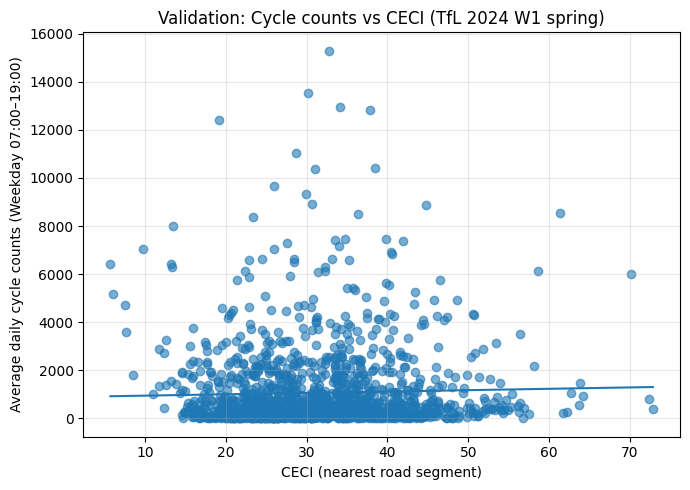

Saved: /content/drive/MyDrive/CASA0004_Cycling/data/tfl_counts_2024W1/validation_site_joined_2024W1.csv


In [ ]:
#相关性与可视化
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

x = joined[COL_CECI].astype(float)
y = joined["avg_daily_flow"].astype(float)

pear_r, pear_p = pearsonr(x, y) if len(joined) >= 3 else (np.nan, np.nan)
spear_r, spear_p = spearmanr(x, y) if len(joined) >= 3 else (np.nan, np.nan)

print(f"Pearson r={pear_r:.3f}, p={pear_p:.3g}")
print(f"Spearman ρ={spear_r:.3f}, p={spear_p:.3g}")

# 散点 + 简单拟合线
plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.6)
if len(joined) >= 2:
    m, b = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 100)
    plt.plot(xx, m*xx + b)
plt.xlabel("CECI (nearest road segment)")
plt.ylabel("Average daily cycle counts (Weekday 07:00–19:00)")
plt.title("Validation: Cycle counts vs CECI (TfL 2024 W1 spring)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "validation_counts_vs_ceci_2024W1.png"), dpi=300)
plt.show()

# 导出匹配结果（做附录/复查）
out_csv = os.path.join(BASE_DIR, "validation_site_joined_2024W1.csv")
joined.drop(columns="geometry").to_csv(out_csv, index=False)
print("Saved:", out_csv)

# 测试一下no2和section3是否存在多重线性关系

In [ ]:
test = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI_nor.gpkg")
print(test.columns)

Index(['id', 'name', 'way_type', 'length_m', 'index_1_nor', 'index_1',
       'base_index', 'fac_1', 'fac_2', 'fac_3', 'fac_4', 'fac_5', 'LTS',
       'index_2_nor', 'index_2', 'fac_gvi', 'fac_no2', 'fac_nat',
       'index_3_nor', 'index_3', 'edge_betweenness', 'edge_closeness_2km',
       'edge_closeness_5km', '_B_log', 'B_norm', 'C2_norm', 'C5_norm',
       'C_multi', 'cqi_index', 'cqi_index_w1', 'cqi_index_w2', 'cqi_index_w3',
       'geometry'],
      dtype='object')


In [ ]:
import pandas as pd

# 取两列
df = test[['fac_no2','index_3']].dropna()

# Pearson 和 Spearman 相关
pear_corr = df['fac_no2'].corr(df['index_3'], method='pearson')
spear_corr = df['fac_no2'].corr(df['index_3'], method='spearman')

print("Pearson correlation:", pear_corr)
print("Spearman correlation:", spear_corr)


Pearson correlation: -0.4377102414294423
Spearman correlation: -0.496461162377843


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = df[['fac_no2','index_3']]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   feature        VIF
0    const  23.608746
1  fac_no2   1.236996
2  index_3   1.236996


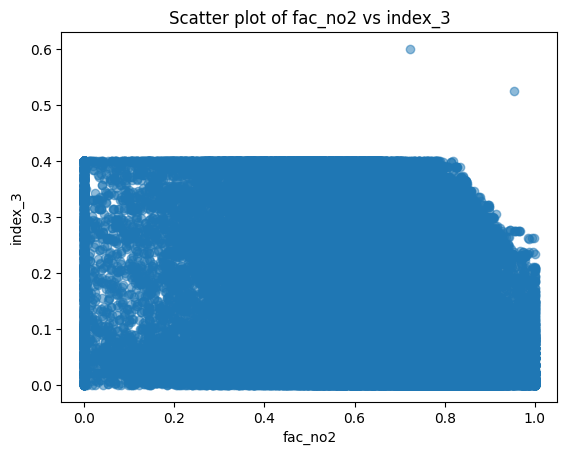

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['fac_no2'], df['index_3'], alpha=0.5)
plt.xlabel("fac_no2")
plt.ylabel("index_3")
plt.title("Scatter plot of fac_no2 vs index_3")
plt.show()


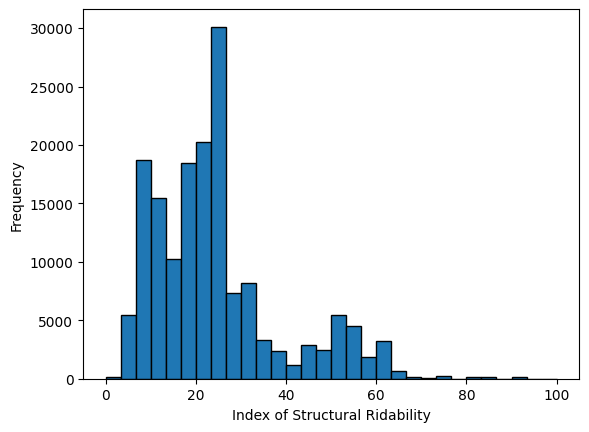

In [ ]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(test["index_1_nor"].dropna(), bins=30, edgecolor="black")
plt.xlabel("Index of Structural Ridability")
plt.ylabel("Frequency")
plt.savefig(os.path.join(BASE_DIR, "index1histogram.png"), dpi=300)
plt.show()